In [22]:
import time
start_time = time.time()
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator
from src.utils import *
from config.paths import *

In [3]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

In [4]:
market_type = 'rtm'
n = 5   # number of days for which evaluation is reqd

### Data Ingestion

In [6]:
# dam = iex_data._get_processed_data('dam')
# rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

In [7]:
dam = load_pickle(PROCESSED_DATA_PATH, 'dam_data')
rtm = load_pickle(PROCESSED_DATA_PATH, 'rtm_data')
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')
print('Data loaded.')

Data loaded.


In [8]:
rtm = rtm[rtm['datetime'] < datetime.now().strftime('%Y-%m-%d')]

### Feature Engineering

In [9]:
dam = featured_data.shift_date(dam, 1) 
weather = featured_data.shift_date(weather, 2)
hydro = featured_data.shift_date(hydro, 2) 
solar = featured_data.shift_date(solar, 2) 
wind = featured_data.shift_date(wind, 2)

data = featured_data.merge_dataframes([rtm, dam, weather, hydro, solar, wind])

In [11]:
training_data = featured_data._get_features(data, weather, market_type)

In [12]:
print('Features created.')

Features created.


### Features & Parameters

In [13]:
# trail and error
n_trials = 50
n_features = 25

In [14]:
best_features, best_params = build_model._features_n_params(training_data, n_trials, n_features)

In [15]:
print('Best Features and Parameters found.')

Best Features and Parameters found.


### Model Training & Evaluation

In [16]:
# training upto this date
training_upto = training_data['datetime'][::96].iloc[-n-1].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [17]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')

In [18]:
if n > X_test[::96].shape[0]:
    n = X_test[::96].shape[0]

Model Evaluation:
  MAPE for 2024-01-16: 20.22
  MAPE for 2024-01-15: 16.82
  MAPE for 2024-01-14: 21.77
  MAPE for 2024-01-13: 25.58
  MAPE for 2024-01-12: 15.69
  Average MAPE for last 5 days: 20.02


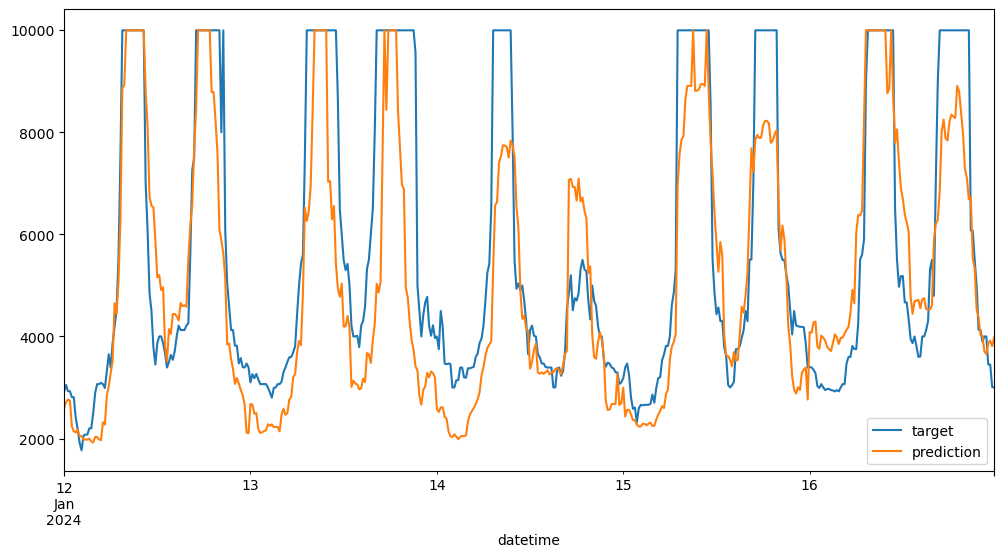

In [19]:
evaluator = ModelEvaluator(model, best_features)
print('Model Evaluation:')
evaluator.evaluate_on_data(X_test, y_test, n, market_type)

### Final Model

In [20]:
# training upto this date
training_upto = datetime.now().date().strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [21]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')
save_pickle(model, MODELS_PATH, f'{market_type}_forecast')
print(f'{market_type}_forecast model saved.')

rtm_forecast model saved.


In [23]:
end_time = time.time()
total_time = (end_time - start_time)/60
print(f'Training time: {total_time:.2f} minutes.')

Training time: 0.05 minutes.
